# Universidad de Buenos Aires
# Procesamiento de Lenguaje Natural - Desafio: 4
# Alumno: Matias Werbin

###Consigna:

Utilizar datos disponibles de convai de conversaciones en ingleś. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)


In [ ]:
# Importacion de librerias
import re
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, LSTM, SimpleRNN, Embedding, Input, Bidirectional
from tensorflow.keras.layers import Concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer


In [ ]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1QPYxMTBSGNmbyGhknznuO3YWLBOJnhUQ&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [ ]:
import json

text_file="data_volunteers.json"
with open(text_file) as f:
  data=json.load(f)

In [ ]:
# Inspección

data

[{'dialog': [{'id': 0,
    'sender': 'participant1',
    'text': 'hi there',
    'evaluation_score': None,
    'sender_class': 'Human'}],
  'start_time': '2018-10-29 03:32:08.296000',
  'end_time': '2018-10-29 03:32:08.296000',
  'bot_profile': ['i like to talk but people have a hard time understanding.',
   'i like to look at blocks and sing about letters.',
   'i like to eat chocolate candy.',
   'when i grow up i want to be a dog.'],
  'user_profile': ['i am a clean eater.',
   'my parents were both very athletic.',
   'i love running and preparing for marathons.',
   'i am a cancer survivor.'],
  'eval_score': None,
  'profile_match': '',
  'participant1_id': {'class': 'User', 'user_id': 'User 00172'},
  'participant2_id': {'class': 'Bot', 'user_id': 'Bot 004'}},
 {'dialog': [{'id': 0,
    'sender': 'participant1',
    'text': 'Hello!',
    'evaluation_score': None,
    'sender_class': 'Human'},
   {'id': 1,
    'sender': 'participant2',
    'text': 'Hi! How are you?',
    'evaluat

In [ ]:
# Campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [ ]:
# Procesamiento de dialodos para modelo seq-seq

chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [ ]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

###  Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [ ]:
# Definición de tamaño máximo del vocabulario
MAX_VOCAB_SIZE=8000

In [ ]:
# Input Tokenizer
input_tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq=input_tokenizer.texts_to_sequences(input_sentences)

In [ ]:
# diccionario word-idx para entradas
word2idx_input=input_tokenizer.word_index
word2idx_input

{'i': 1,
 'you': 2,
 'do': 3,
 'what': 4,
 'a': 5,
 'to': 6,
 'are': 7,
 'for': 8,
 'am': 9,
 'how': 10,
 'hi': 11,
 'like': 12,
 'living': 13,
 'love': 14,
 'is': 15,
 'have': 16,
 'm': 17,
 'that': 18,
 'hello': 19,
 'oh': 20,
 'your': 21,
 'ok': 22,
 'read': 23,
 'good': 24,
 'yes': 25,
 'the': 26,
 'it': 27,
 'not': 28,
 'no': 29,
 's': 30,
 'any': 31,
 'work': 32,
 'in': 33,
 'u': 34,
 'me': 35,
 'my': 36,
 'about': 37,
 'and': 38,
 'from': 39,
 't': 40,
 'of': 41,
 'go': 42,
 'play': 43,
 'today': 44,
 'too': 45,
 'so': 46,
 'don': 47,
 'hobbies': 48,
 'nice': 49,
 'fine': 50,
 'name': 51,
 'where': 52,
 'cool': 53,
 'doing': 54,
 'there': 55,
 'hey': 56,
 'know': 57,
 'bye': 58,
 'see': 59,
 'great': 60,
 'well': 61,
 'favorite': 62,
 'sure': 63,
 'old': 64,
 'games': 65,
 'pets': 66,
 'why': 67,
 'beach': 68,
 'sorry': 69,
 'at': 70,
 'nothing': 71,
 'mean': 72,
 'lot': 73,
 'fun': 74,
 'live': 75,
 'okay': 76,
 'thanks': 77,
 'also': 78,
 'can': 79,
 'student': 80,
 'city': 81

In [ ]:
# Cantidad de palabras en el vocabulario
print("La cantidad de palabras en el Vocabulario de Entrada es:", len(word2idx_input))

La cantidad de palabras en el Vocabulario de Entrada es: 1799


In [ ]:
# Secuencia más larga de entrada
max_input_len_seq=max(len(seq) for seq in input_integer_seq)
print("La secuencia de entrada más larga es:", max_input_len_seq)

La secuencia de entrada más larga es: 9


In [ ]:
# Output Tokenizer
output_tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>","<eos>"] + output_sentences)
output_input_integer_seq=output_tokenizer.texts_to_sequences(output_sentences_inputs)
output_integer_seq=output_tokenizer.texts_to_sequences(output_sentences)


In [ ]:
# diccionario word-idx para salidas
word2idx_output=output_tokenizer.word_index
word2idx_output

{'<eos>': 1,
 'you': 2,
 'i': 3,
 'do': 4,
 'what': 5,
 'a': 6,
 'are': 7,
 'to': 8,
 'for': 9,
 'how': 10,
 'am': 11,
 'living': 12,
 'like': 13,
 'love': 14,
 'have': 15,
 'is': 16,
 'm': 17,
 'your': 18,
 'read': 19,
 'hello': 20,
 'oh': 21,
 'good': 22,
 'that': 23,
 'hi': 24,
 'it': 25,
 'the': 26,
 'any': 27,
 'not': 28,
 'yes': 29,
 'u': 30,
 'and': 31,
 'work': 32,
 'about': 33,
 'me': 34,
 's': 35,
 'in': 36,
 'no': 37,
 'my': 38,
 'ok': 39,
 'fine': 40,
 'from': 41,
 'today': 42,
 'of': 43,
 'hobbies': 44,
 'doing': 45,
 't': 46,
 'where': 47,
 'name': 48,
 'play': 49,
 'too': 50,
 'go': 51,
 'so': 52,
 'well': 53,
 'see': 54,
 'great': 55,
 'don': 56,
 'favorite': 57,
 'bye': 58,
 'pets': 59,
 'nice': 60,
 'know': 61,
 'there': 62,
 'at': 63,
 'hey': 64,
 'why': 65,
 'can': 66,
 'sure': 67,
 'live': 68,
 'cool': 69,
 'fun': 70,
 'thanks': 71,
 'old': 72,
 'games': 73,
 'beach': 74,
 'job': 75,
 'tell': 76,
 'with': 77,
 'student': 78,
 'mean': 79,
 'sorry': 80,
 'girl': 81,


In [ ]:
# Cantidad de palabras en el vocabulario
print("La cantidad de palabras en el Vocabulario de Salida es:", len(word2idx_output))

La cantidad de palabras en el Vocabulario de Salida es: 1806


In [ ]:
# Secuencia de más larga de salida
max_output_len_seq=max(len(seq) for seq in output_integer_seq)
print(f"La secuencia de salida más larga es {max_output_len_seq}")

La secuencia de salida más larga es 10


In [ ]:
num_words_output = min(len(word2idx_output) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
num_words_output

1807

In [ ]:
# Veamos si nuestro Tokenizer de outputs genero tokens para eos y sos

idx_eos=word2idx_output['<eos>']
idx_sos=word2idx_output['<sos>']

print(f"Los indices asociados a <eos> y <sos> son {idx_eos} y {idx_sos}, respectivamente")

Los indices asociados a <eos> y <sos> son 1 y 815, respectivamente


In [ ]:
from tensorflow.keras.utils import to_categorical

print(f"Cantidad de rows en dataset:{len(input_integer_seq)}")

encoder_input_sequences=pad_sequences(input_integer_seq, maxlen=max_input_len_seq,padding='post')
print("Shape input encoder", encoder_input_sequences.shape)

decoder_input_sequences=pad_sequences(output_input_integer_seq,maxlen=max_output_len_seq, padding='post')
print("Shape input decoder", decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_output_len_seq, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
print("Shape targets decoder", decoder_targets.shape)


Cantidad de rows en dataset:6033
Shape input encoder (6033, 9)
Shape input decoder (6033, 10)
Shape targets decoder (6033, 10, 1807)


### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [ ]:
# Descargar embbedings de glove
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [ ]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [ ]:
# Inicializamos Embeddings
model_embeddings=GloveEmbeddings()

In [ ]:
# Cargamos matriz de embeddings para la entrada

print('preparing input embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words_entrada = min(MAX_VOCAB_SIZE, len(word2idx_input)) # vocab_size
embedding_matrix_entrada = np.zeros((nb_words_entrada + 1 , embed_dim))
for word, i in word2idx_input.items():
    if i >= nb_words_entrada:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix_entrada[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('Numero de embeddings nulos (input):', np.sum(np.sum(embedding_matrix_entrada, axis=1) == 0))


preparing input embedding matrix...
Numero de embeddings nulos (input): 39


In [ ]:
# Dimensión de los embeddings de la secuencia de entrada
embedding_matrix_entrada.shape

(1800, 50)

In [ ]:
# # Cargamos matriz de embeddings para la salida

print('preparing output embedding matrix...')
words_not_found = []

# word_index provieen del tokenizer

nb_words_salida = min(MAX_VOCAB_SIZE, len(word2idx_output)) # vocab_size
embedding_matrix_salida = np.zeros((nb_words_salida + 1 , embed_dim))
for word, i in word2idx_output.items():
    if i >= nb_words_salida:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix_salida[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('Numero de embeddings nulos (output):', np.sum(np.sum(embedding_matrix_salida, axis=1) == 0))

preparing output embedding matrix...
Numero de embeddings nulos (output): 43


In [ ]:
# Dimensión de los embeddings de la secuencia de salida
embedding_matrix_salida.shape

(1807, 50)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [ ]:
units=128

# Encoder

encoder_inputs = Input(shape=(max_input_len_seq,))

encoder_embedding_layer = Embedding(
    input_dim=nb_words_entrada + 1 ,
    output_dim=embed_dim,
    input_length=max_input_len_seq,
    weights=[embedding_matrix_entrada],
    trainable=False
)

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# Decoder (LSTM)

decoder_inputs = Input(shape=(max_output_len_seq,))

decoder_embedding_layer = Embedding(
    input_dim=nb_words_salida + 1,
    output_dim=embed_dim,
    input_length=max_output_len_seq,
    weights=[embedding_matrix_salida],
    trainable=False
)

decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Decoder (Dense)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()



Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 9)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 9, 50)          │         90,000 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 10, 50)         │         90,350 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ [(None, 128), (None,   │         91,648 │ embedding_4[0][0]      │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ [(None, 10, 128),      │         91,648 │ embedding_5[0][0],     │
│                           │ (None, 128), (None,    │                │ lstm_4[0][1],          │
│                           │ 128)]                  │                │ lstm_4[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 10, 1807)       │        233,103 │ lstm_5[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 596,749 (2.28 MB)

 Trainable params: 416,399 (1.59 MB)

 Non-trainable params: 180,350 (704.49 KB)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

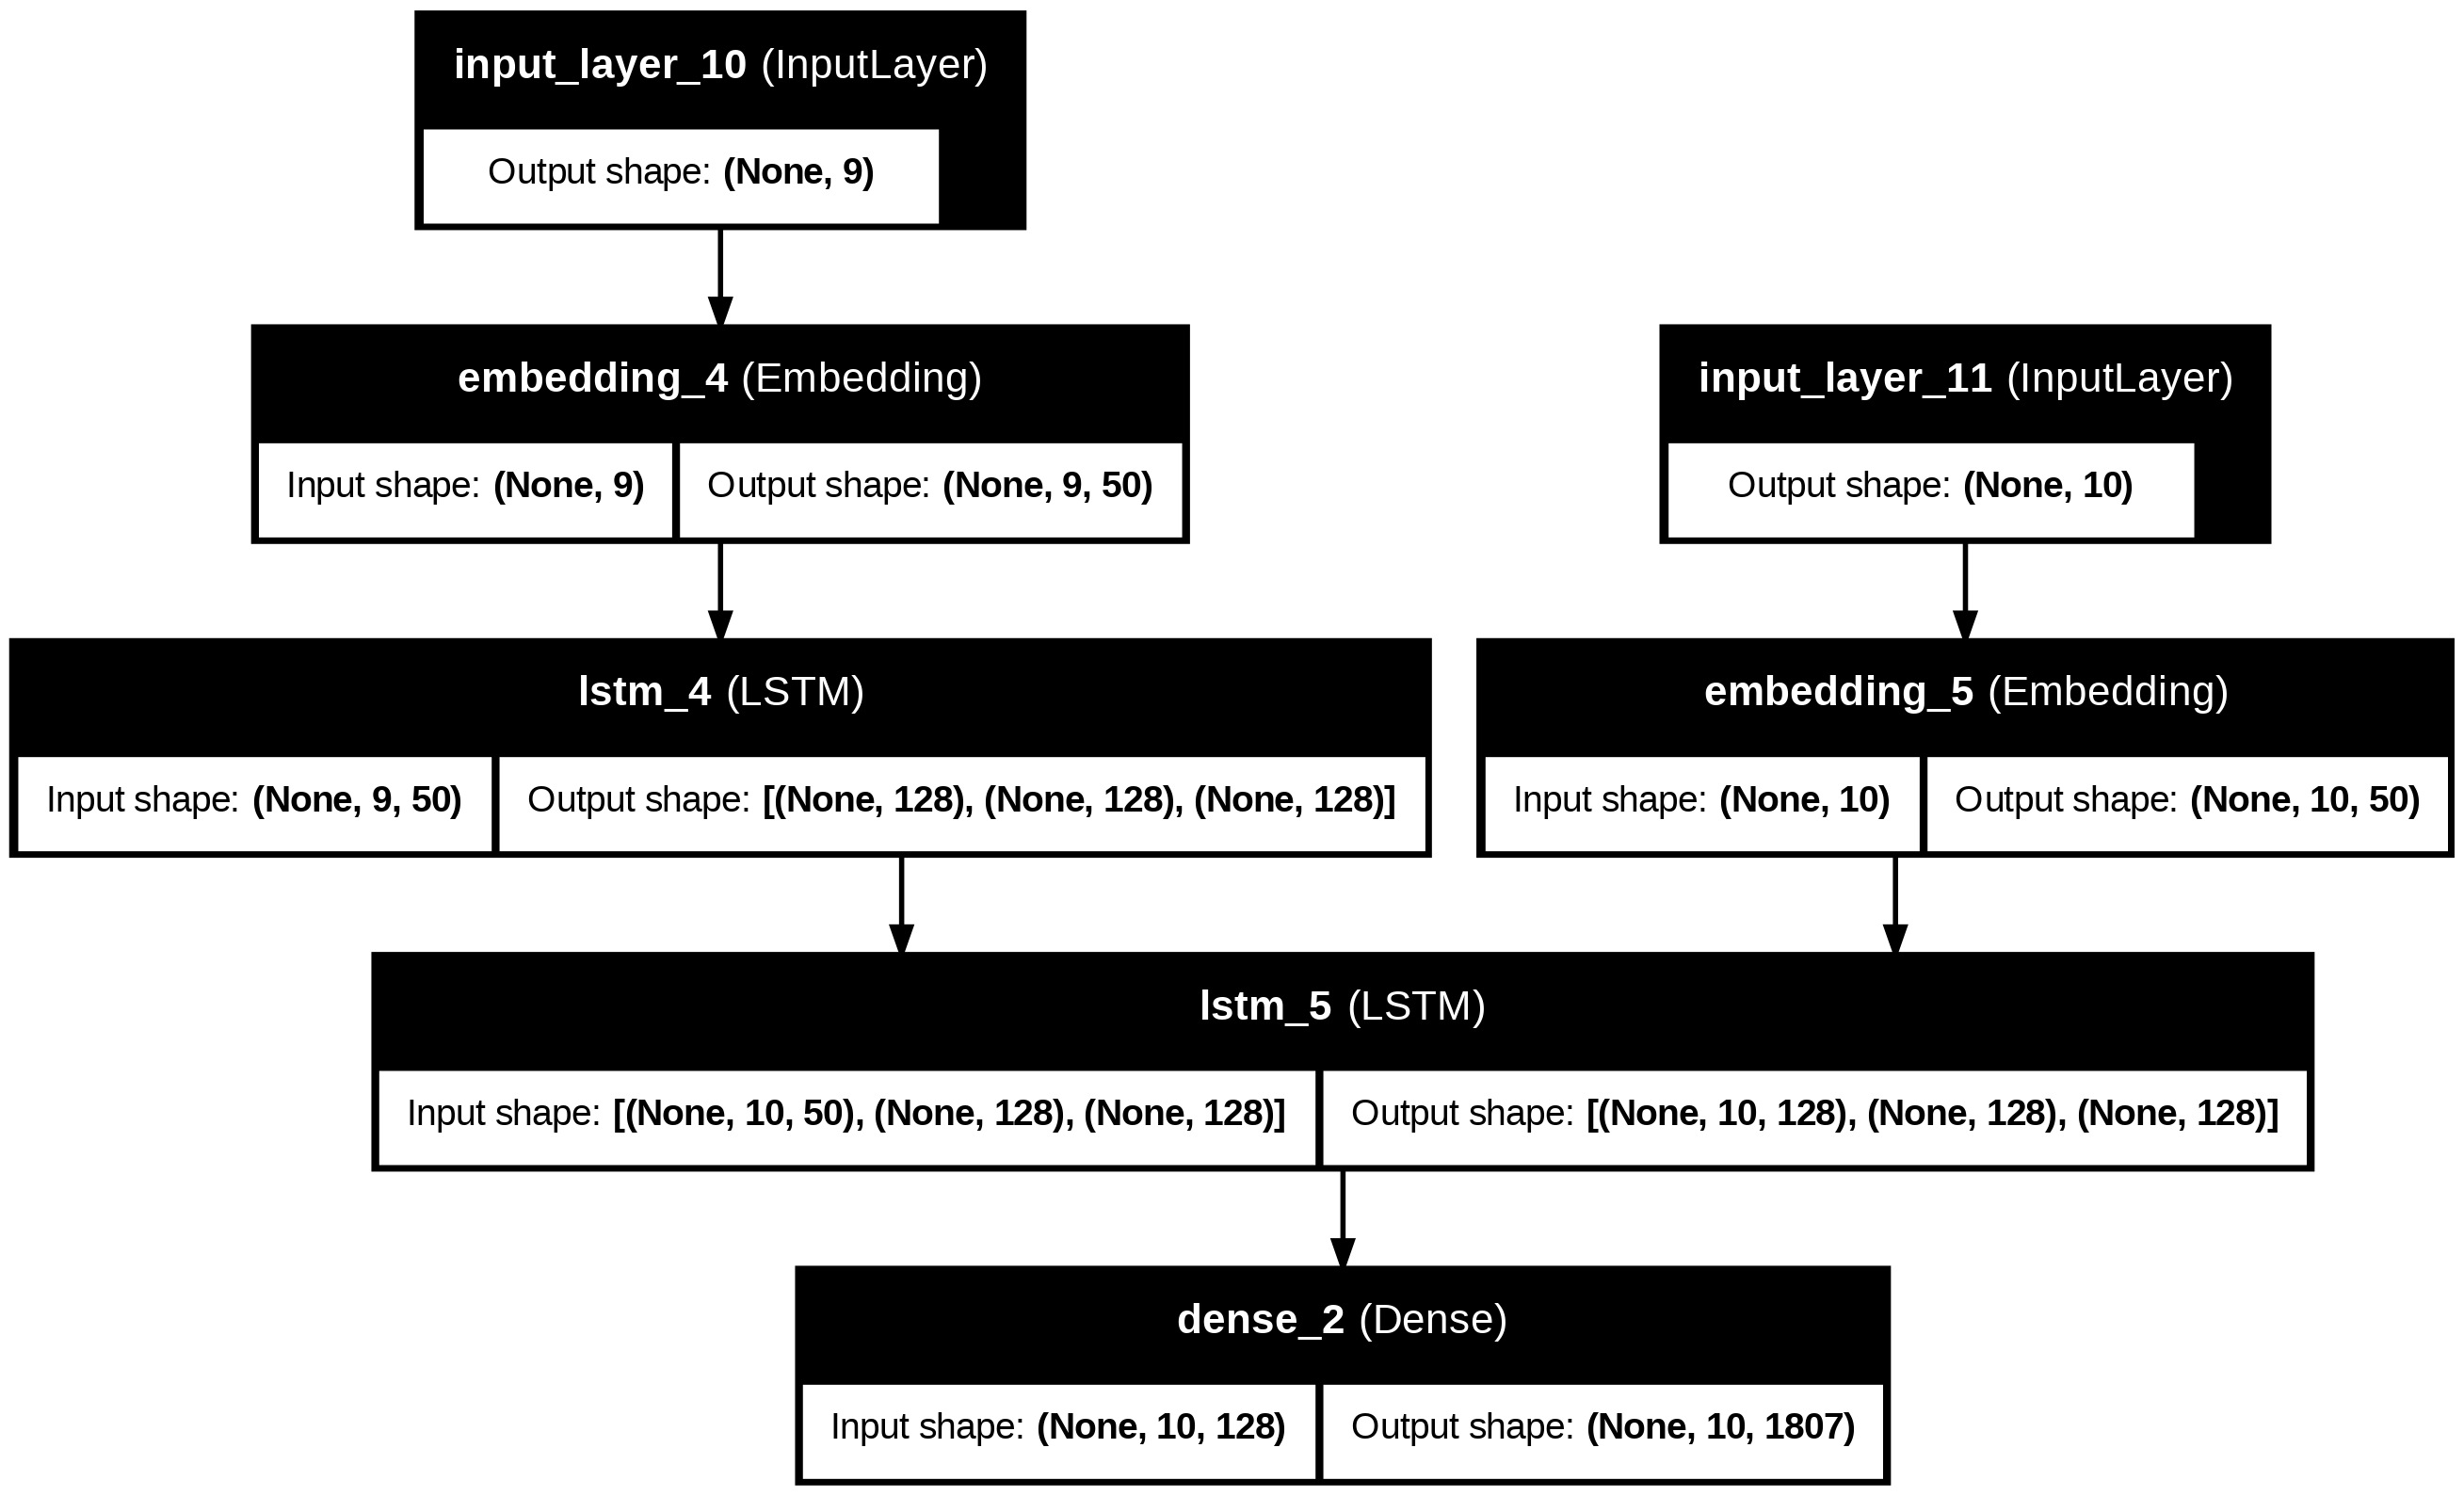

In [ ]:
# Visualizacion de modelo entero
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='seq2seq_model.png', show_shapes=True, show_layer_names=True)


In [ ]:
history = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=30,
    validation_split=0.2)

Epoch 1/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.4742 - loss: 4.1671 - val_accuracy: 0.6287 - val_loss: 2.2589
Epoch 2/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.6256 - loss: 2.1098 - val_accuracy: 0.6587 - val_loss: 2.0921
Epoch 3/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.6752 - loss: 1.8595 - val_accuracy: 0.6792 - val_loss: 1.9706
Epoch 4/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.6949 - loss: 1.7272 - val_accuracy: 0.6833 - val_loss: 1.9149
Epoch 5/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.7091 - loss: 1.6216 - val_accuracy: 0.6898 - val_loss: 1.8800
Epoch 6/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.7140 - loss: 1.5764 - val_accuracy: 0.6896 - val_loss: 1.8489
Epoch 7/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.7198 - loss: 1.5055 - val_accuracy: 0.6945 - val_loss: 1.8229
Epoch 8/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.7234 - loss: 1.4624 - 

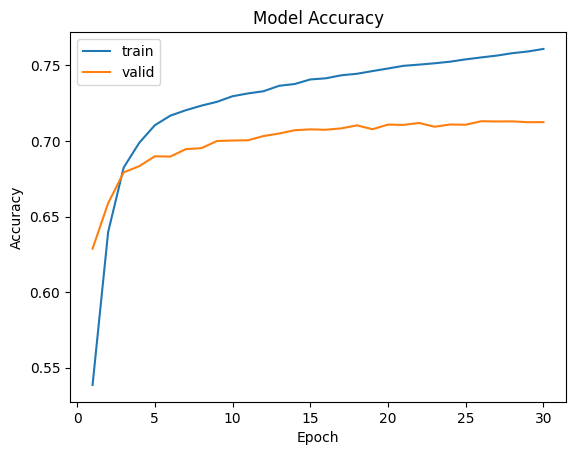

In [ ]:
import matplotlib.pyplot as plt

epoch_count = range(1, len(history.history['accuracy']) + 1)
plt.plot(epoch_count, history.history['accuracy'], label='train')
plt.plot(epoch_count, history.history['val_accuracy'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()


### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

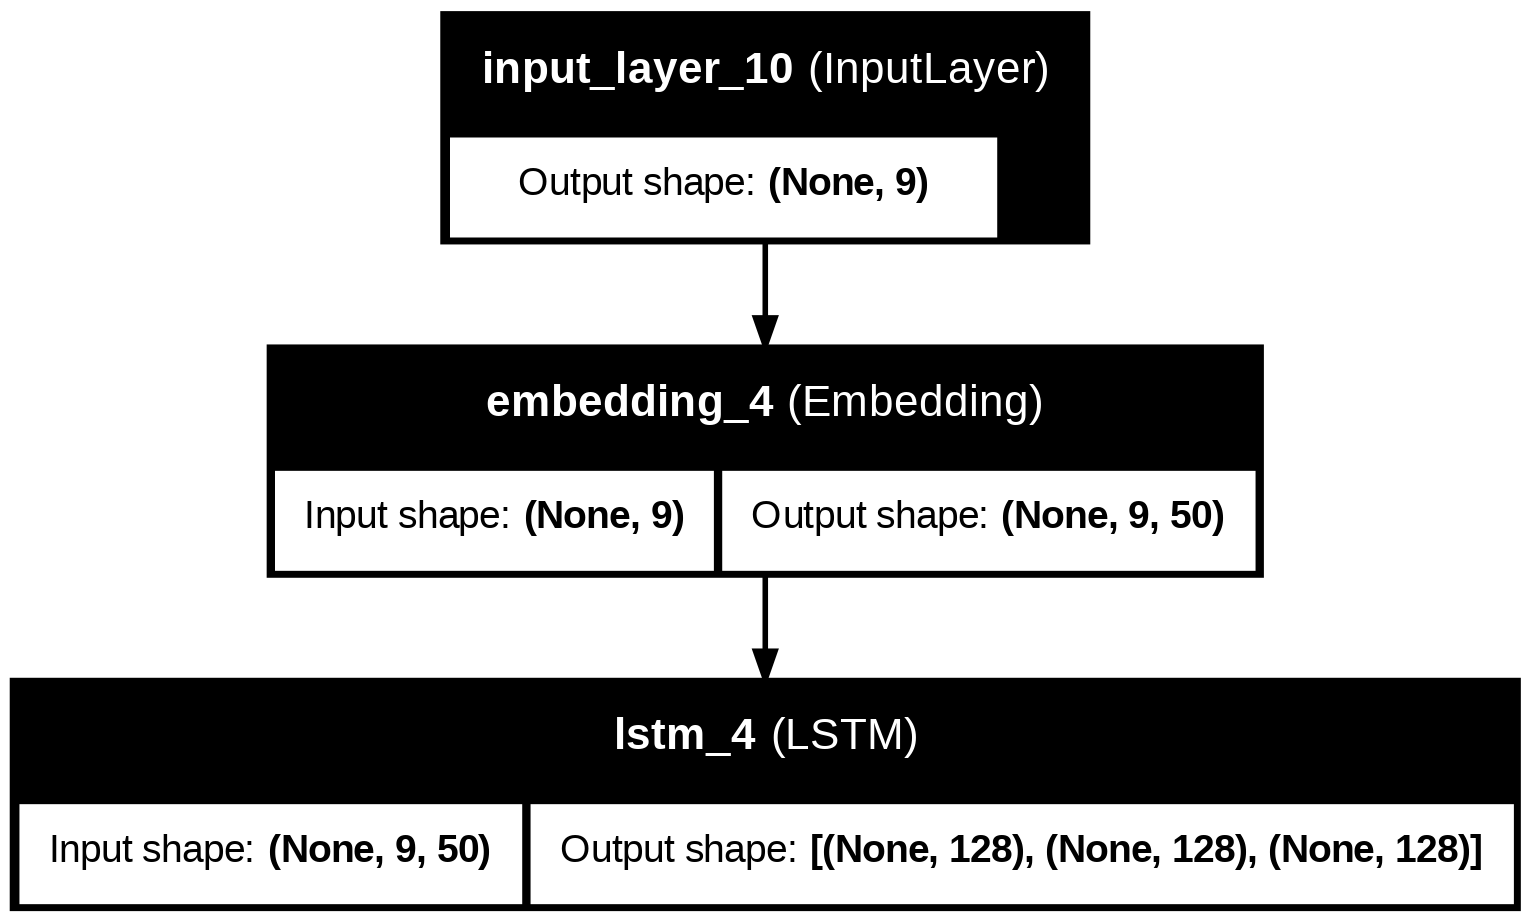

In [ ]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

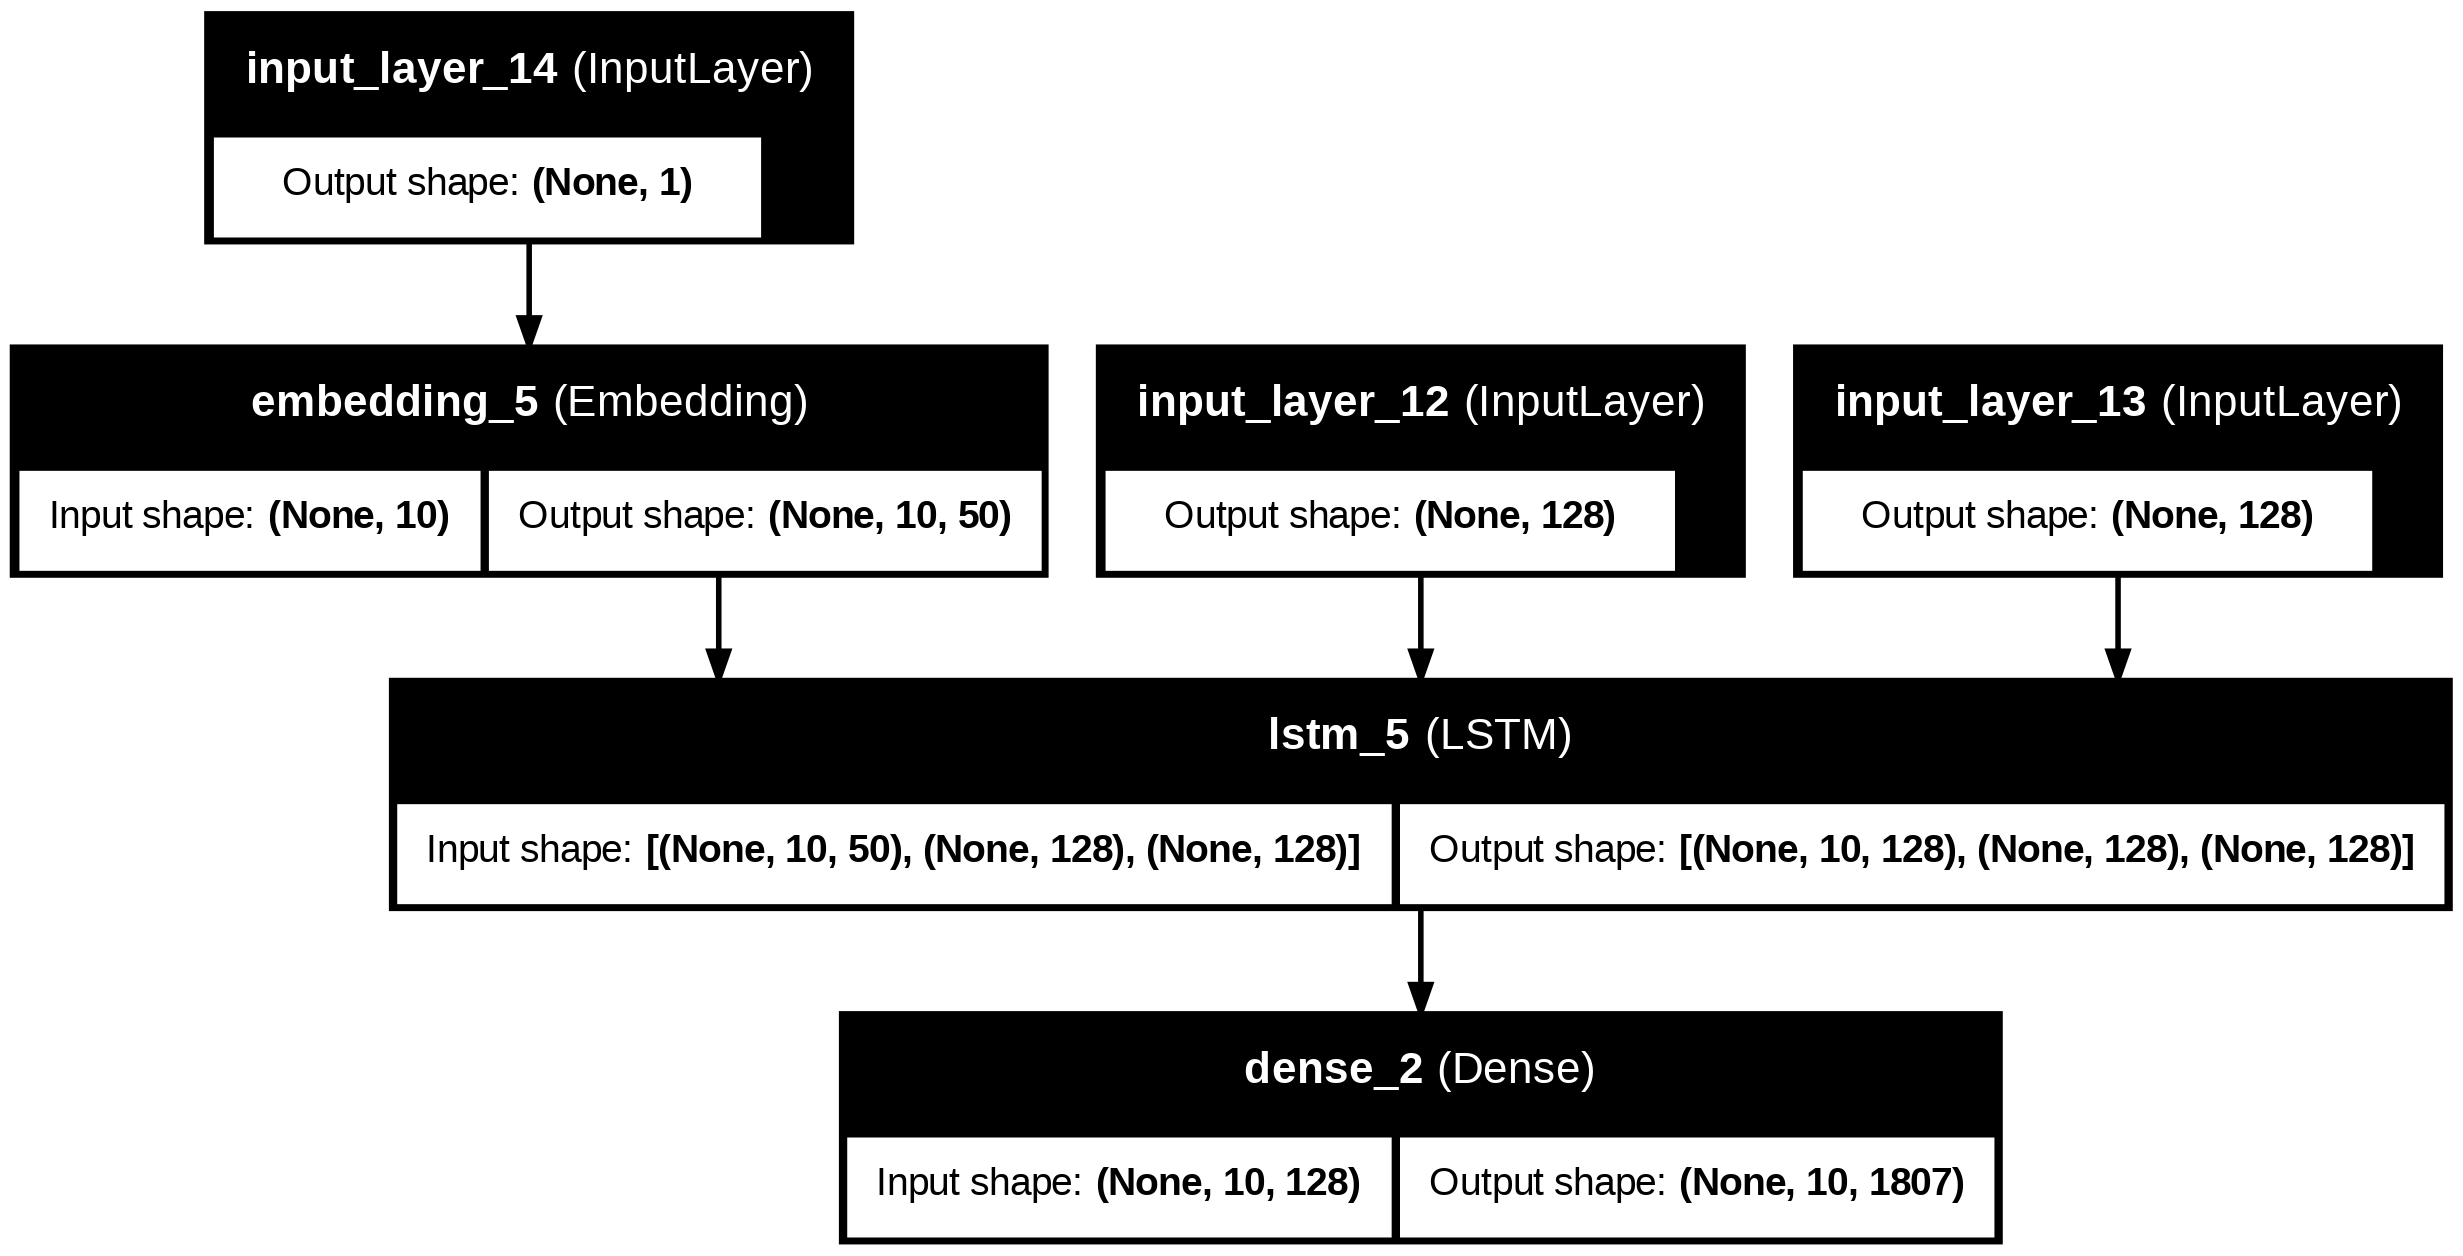

In [ ]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(units,))
decoder_state_input_c = Input(shape=(units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# idx2word:
idx2word_input = {v:k for k, v in word2idx_input.items()}
idx2word_target = {v:k for k, v in word2idx_output.items()}

In [ ]:
def question_answer(input_seq):
    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder"
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_output['<sos>']

    # Se obtiene el indice que finaliza la inferencia
    eos = word2idx_output['<eos>']

    output_sentence = []
    for _ in range(max_output_len_seq):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar ídx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dado la ultimo prediccion
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentacion)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
answer = question_answer(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
-
Input: taylor nice to meet you 
Response: i like to read


In [ ]:
question = "Do like the play video games?"
print('Input:', question)
integer_seq_test = input_tokenizer.texts_to_sequences([question])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len_seq,padding='post')
answer = question_answer(encoder_sequence_test)
print('Response:', answer)

Input: Do like the play video games?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Response: do you have any hobbies


In [ ]:
question = "Are you vegan?"
print('Input:', question)
integer_seq_test = input_tokenizer.texts_to_sequences([question])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len_seq, padding='post')
answer = question_answer(encoder_sequence_test)
print('Response:', answer)

Input: Are you vegan?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Response: i love to read


In [ ]:
question = "Do you read?"
print('Input:', question)
integer_seq_test = input_tokenizer.texts_to_sequences([question])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len_seq, padding='post')
answer = question_answer(encoder_sequence_test)
print('Response:', answer)

Input: Do you read?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Response: i love to read


In [ ]:
question = "Are you a girl?"
print('Input:', question)
integer_seq_test = input_tokenizer.texts_to_sequences([question])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len_seq, padding='post')
answer = question_answer(encoder_sequence_test)
print('Response:', answer)

Input: Are you a girl?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Response: i am not sure what you mean


In [ ]:
question = "Hi, how are you?"
print('Input:', question)
integer_seq_test = input_tokenizer.texts_to_sequences([question])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len_seq, padding='post')
answer = question_answer(encoder_sequence_test)
print('Response:', answer)

Input: Hi, how are you?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Response: i am fine


**Conclusión:**

El modelo muestra que puede generar respuestas que son contextual y semánticamente correctas para las preguntas de prueba. Para mejorar la métrica de precisión y obtener respuestas aún más precisas, se podría considerar apilar capas LSTM en el encoder y el decoder